#1 Data

###1.1 Getting data

In [1]:
import pandas as pd

data = pd.read_csv('stars.csv')
data.head()
#data['Type'].nunique()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


In [2]:
data = data.drop(columns =['Color', 'Spectral_Class'])
data['Temperature'] = data['Temperature'].astype(float)
X = data.drop(columns = 'Type')
# y = data['Type']
print(X.dtypes)

Temperature    float64
L              float64
R              float64
A_M            float64
dtype: object


###1.2 Standardizing

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_stand = scaler.fit_transform(X)
X_stand[0]

array([-0.7793821 , -0.59862356, -0.45920992,  1.11674535])

###1.3 Visualizing

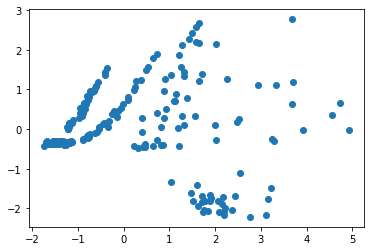

In [4]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
X_trans = pca.fit_transform(X_stand)
plt.scatter(X_trans[:, 0], X_trans[:, 1])
plt.show()

#2 Decision tree learning


### 2.1 Computing score

In [5]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import silhouette_score

n = len(X)
labels = range(0, n)
scores = []
for i in np.arange(0.05, 1, 0.05):
  model = DecisionTreeClassifier(criterion='entropy',
                                 min_impurity_decrease=i)
  model.fit(X, labels)
  labels = model.apply(X)
  sil = silhouette_score(X_stand, labels)
  scores.append({'param': round(i, 2),
                 'score': round(sil, 4)})
  
scores[:5]

[{'param': 0.05, 'score': -0.0856},
 {'param': 0.1, 'score': 0.0054},
 {'param': 0.15, 'score': 0.1235},
 {'param': 0.2, 'score': 0.1235},
 {'param': 0.25, 'score': 0.1235}]

###2.2 Visualizing score

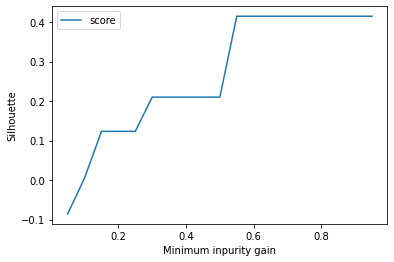

In [6]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in scores]
score_list = [x['score'] for x in scores]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Silhouette')
ax.set_xlabel('Minimum inpurity gain')
plt.plot(param_list, score_list, label='score')
ax.legend()
plt.show()

### 2.3 Computing score gain

In [7]:
scores[0]['diff'] = 0
for i, score in enumerate(scores):
  if i == 0:
    continue
  score['diff'] = score['score'] - scores[i-1]['score']

scores[:5]

[{'param': 0.05, 'score': -0.0856, 'diff': 0},
 {'param': 0.1, 'score': 0.0054, 'diff': 0.091},
 {'param': 0.15, 'score': 0.1235, 'diff': 0.1181},
 {'param': 0.2, 'score': 0.1235, 'diff': 0.0},
 {'param': 0.25, 'score': 0.1235, 'diff': 0.0}]

### 2.4 Visualizing score gain

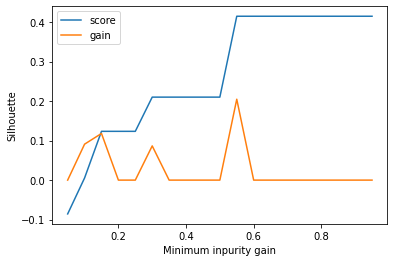

In [8]:
from matplotlib import pyplot as plt

param_list = [x['param'] for x in scores]
score_list = [x['score'] for x in scores]
diff_list = [x['diff'] for x in scores]

fig = plt.figure()
ax = fig.add_subplot()
ax.set_ylabel('Silhouette')
ax.set_xlabel('Minimum inpurity gain')
plt.plot(param_list, score_list, label='score')
plt.plot(param_list, diff_list, label='gain')
ax.legend()
plt.show()

### 2.5 Построение реш. дерева

In [9]:
scores_sorted = sorted(scores, key=lambda x: x['diff'], reverse=True)
threshold = scores_sorted[0]['param']

labels = range(0, n)
model = DecisionTreeClassifier(criterion='entropy',
                               min_impurity_decrease=threshold)
model.fit(X, labels)

DecisionTreeClassifier(criterion='entropy', min_impurity_decrease=0.55)

### 2.6 Визуализация дерева

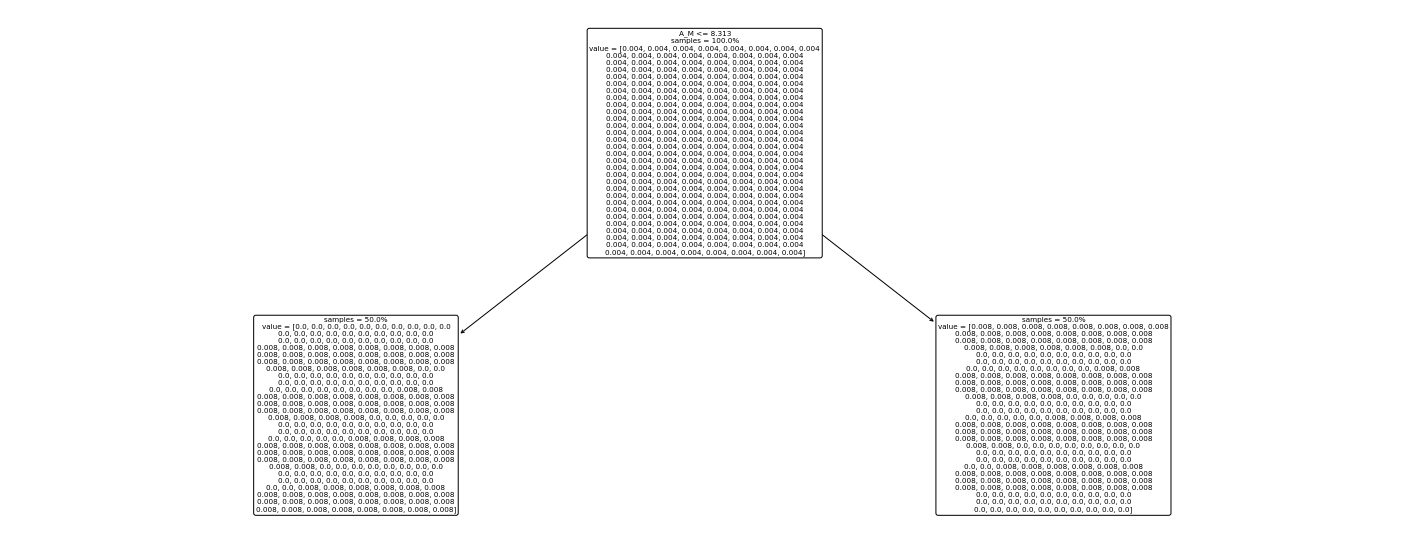

In [10]:
from sklearn import tree

fig = plt.figure(figsize=(25, 10))
tree.plot_tree(model,
               feature_names = X.columns,
               impurity=False,
               proportion=True,
               rounded=True)
plt.show()

# 3. Построение иерархии OWL классов

### 3.1 Извлечение данных из дерева

In [11]:
n_nodes = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right
features = model.tree_.feature
thresholds = model.tree_.threshold

def make_node(i):
  node = {}
  node['parentID'] = i
  node['feature'] = X.columns[features[i]]
  node['threshold'] = round(thresholds[i], 2)
  return node

nodes = []
for i in range(0, n_nodes):
  if children_left[i] != -1:
    node = make_node(i)
    node['ID'] = children_left[i]
    node['comparison'] = '<='
    nodes.append(node)
  if children_right[i] != -1:
    node = make_node(i)
    node['ID'] = children_right[i]
    node['comparison'] = '>'
    nodes.append(node)

nodes[:5]

[{'parentID': 0,
  'feature': 'A_M',
  'threshold': 8.31,
  'ID': 1,
  'comparison': '<='},
 {'parentID': 0,
  'feature': 'A_M',
  'threshold': 8.31,
  'ID': 2,
  'comparison': '>'}]

### 3.2 Создание онтологии и свойства

In [12]:
!pip install owlready2
from owlready2 import *
import types

onto = get_ontology('onto.owl')

with onto:
  for feature in X.columns:
    onto_feature = types.new_class(feature, (DataProperty,))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###3.3 Создание классов

In [13]:
with onto:
  for node in nodes:
    parent = node['parentID']
    if parent == 0:
      onto_parent = Thing
    else:
      onto_parent = onto[f'Class_{parent}']
    onto_class = types.new_class(f'Class_{node["ID"]}', (onto_parent,))

    onto_feature = onto[node['feature']]
    threshold = node['threshold']
    if node['comparison'] == '<=':
      onto_class.equivalent_to.append(onto_feature.some(
          ConstrainedDatatype(float, max_inclusive = threshold)))
    else:
      onto_class.equivalent_to.append(onto_feature.some(
          ConstrainedDatatype(float, min_exclusive = threshold)))

onto.save('onto.owl', format='ntriples')

### 3.4 Создание сущностей

In [14]:
i = 0

with onto:
  row = X.loc[i]
  inst = Thing(f'inst{i}')
  for feature in X.columns:
    onto_feature = onto[feature]
    onto_feature[inst].append(float(row[feature]))

### 3.5 Classifying with the reasoning

In [15]:
with onto:
  sync_reasoner_pellet()
  print(inst.is_a)

onto.save('onto_classified.owl', format='ntriples')

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.7/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/xml-apis-1.4.01.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-core-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/commons-codec-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/slf4j-api-1.6.4.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jena-tdb-0.10.0.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/pellet-2.3.1.jar:/usr/local/lib/python3.7/dist-packages/owlready2/pellet/jgrapht-jdk1.5.jar:/usr/local/lib/python3.7/dist

[onto.Class_2]


* Owlready2 * Pellet took 2.4676148891448975 seconds
* Owlready * Reparenting onto.inst0: {owl.Thing} => {onto.Class_2}
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)
